# Project 1: Image Classification

## Task 0: Getting Started

Read the getting started guide titled **"Python for Deep Learning"** and get familiar with Python and PyTorch. Read the provided code below and get familiar with the commands and their parameters to understand what the code is trying to do. We recommend to spend a fair amount of time to understand all the different parts of the code. This understanding will be important for this and future projects.

The goal of this project is to implement the *“Hello World!”* program of deep learning: designing and training a network that performs image classification. The dataset we will be using is CIFAR10 which is a large set of images that are classified into 10 classes (airplane, bird, cat, etc.).

## Task 1:  Data Loading (10 points)
Complete the **DataLoader** below which we will use to load images of the cifar10 dataset provided by torchvision. Your task is to normalize it by shifting and scaling it by a factor of 0.5. For the training set, introduce random transformations (e.g. flips) for data augmentation.

In [40]:
from __future__ import print_function, division

import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
print(torch.__version__)
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

# Data augmentation, tensor conversion and normalization for training
# Just normalization and tensor conversion for testing
mean, std = (0.5,), (0.5,)
data_transforms = {
    'train': transforms.Compose([transforms.RandomHorizontalFlip(), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize(mean, std)]),
    'test': transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean, std)])
}

# Download (if not downloaded before) & Load CIFAR10
torch.random.manual_seed(0)
image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', train=(x=='train'), download=True, transform=data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=(x=='train'), num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# Ship to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(f"The classes found in CIFAR-10 are: {class_names}")

2.0.0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
The classes found in CIFAR-10 are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations. The results should look like:

<img src="https://i.imgur.com/Sa6l1go.png" width="400" align="left">

torch.Size([4, 3, 32, 32])
torch.Size([3, 36, 138])
(36, 138, 3)


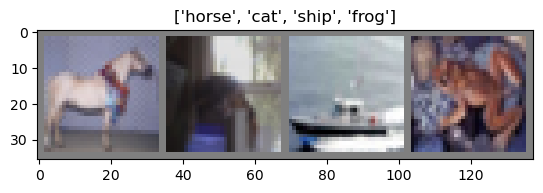

In [50]:
# TODO Task 1:  Run this cell and try to understand the output of each step
def imshow(inp, title=None):
    """Imshow for Tensor."""
    print(inp.shape)
    inp = inp.numpy().transpose((1, 2, 0))
    print(inp.shape)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Task 2: Basic Networks (20 points)
1. Create a Fully connected Network (FcNet) using the following layers in the Jupyter Notebook (use the non-linearities wherever necessary):
```
FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the FcNet for **3** epoches and record the training time and accuracy in your final report.

2. Create a Convolutional Network (ConvNet) using the following layers in the Jupyter Notebook (use the non-linearities wherever necessary):
```
ConvNet(
  (conv): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the ConvNet for **3** epoches and record the training time and accuracy in your final report. Note: You can reuse the conv layers to match the in_features of fc1. 

*Use the default SGD optimizer ( lr=0.001, momentum=0.9) for training.

### Model training code 

In [3]:
def train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_weight.pth'):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train': model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), save_path)
    return model

### Model test code 

In [4]:
def test_model(model, load_path='saved_weight.pth'):    
    # load the model weights
    model.load_state_dict(torch.load(load_path))
    
    since = time.time()

    for phase in ['test']:
        if phase == 'test':
            model.eval()   # Set model to evaluate mode
            
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
           

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Acc: {:.4f}'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return epoch_acc

### 1) FC Network

In [5]:
# 1) Define a Fully Connected Neural Network
# Please advise the Pytorch Documentation and use the appropiate calls

class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        # TODO Task 2:  Define the layers 
        self.fc1 = nn.Linear(in_features=3072, out_features=1024, bias=True)
        self.fc2 = nn.Linear(in_features=1024, out_features=400, bias=True)
        self.fc3 = nn.Linear(in_features=400, out_features=84, bias=True)
        self.fc4 = nn.Linear(in_features=84, out_features=10, bias=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        # TODO Task 2:  Define the forward pass
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model_ft = FcNet() #Define the model
model_ft = model_ft.to(device) 
print(model_ft, device)

# TODO Task 2:  Define loss criterion - cross entropy loss
criterion = F.cross_entropy

# TODO Task 2:  Define Optimizer
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# TODO Task 2:  Train the model
model_train = train_model(model_ft, criterion, optimizer, num_epochs=3, save_path='saved_FcNet_weight.pth')

# TODO Task 2:  Test the model
model_test = test_model(model_ft, load_path='saved_FcNet_weight.pth')

FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
) cuda:0
Epoch 0/2
----------
train Loss: 1.6930 Acc: 0.3933
Epoch 1/2
----------
train Loss: 1.4432 Acc: 0.4888
Epoch 2/2
----------
train Loss: 1.3389 Acc: 0.5216
Training complete in 1m 46s
test Acc: 0.5302
Testing complete in 0m 11s


### 2) CNN

In [7]:
# 2) Define a Convolutional Neural Network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # TODO Task 2:  Define the CNN layers 
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
        self.fc1 = nn.Linear(in_features=400, out_features=120, bias=True)
        self.fc2 = nn.Linear(in_features=120, out_features=84, bias=True)
        self.fc3 = nn.Linear(in_features=84, out_features=10, bias=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        # TODO Task 2:  Define the forward pass
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 400)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ft = ConvNet() #Define the model
model_ft = model_ft.to(device)
print(model_ft, device)

# TODO Task 2:  Define loss criterion - cross entropy loss
criterion = F.cross_entropy

# TODO Task 2:  Define Optimizer
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# TODO Task 2:  Train the model
model_train = train_model(model_ft, criterion, optimizer, num_epochs=3, save_path='saved_CNNNet_weight.pth')

# TODO Task 2:  Test the model
model_test = test_model(model_ft, load_path='saved_CNNNet_weight.pth')

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
) cuda:0
Epoch 0/2
----------
train Loss: 1.7515 Acc: 0.3517
Epoch 1/2
----------
train Loss: 1.3389 Acc: 0.5186
Epoch 2/2
----------
train Loss: 1.2162 Acc: 0.5690
Training complete in 1m 50s
test Acc: 0.5652
Testing complete in 0m 11s


## Task 3.A: Design Your Network (30 points)
Define your own Convolutional Network (MyNet) based on the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) architecture (see Sec. 4.2 for the original architecture used). Here we will experiment with different configurations. Add following modifications and train the Network for **25** epoches. Keep the best settings for each step (for each step, record the training accuracy of the last epoch and test accuracy in your report):

- Modify the number of ResNet blocks per layer: For Simplicity, implement a three-layered ResNet architecture. For each layer, try 1 , 2 and 3 number of ResNet blocks (3 configurations in total). You can choose any of the downsampling methods to match the tensor sizes wherever necessary. Use 2D average pooling layer before applying the final linear layer. For the three layers keep the number of filters 16, 32 and 64 respectively. Follow the ResNet paper to select the kernel size, paddings, optimizer/learning rate, strides, activations and **Batch Normalization** (select a suitable batch size) layers for this task. Print the model summary of the selected model.

#### *Bonus Points: Define a validation set within the training set to monitor underfitting/overfitting after every epoch for each task. (Hint modify dataloaders and/or train_model function) 

### Design Your Network

In [5]:
# Task 3.A: Configuration 1
from types import SimpleNamespace

class MyNet(nn.Module):
    def __init__(self, num_classes=10, num_blocks=[3,3,3], c_hidden=[16,32,64], **kwargs):
        super(MyNet, self).__init__()
        # TODO Task 3: Design Your Network
        self.hparams = SimpleNamespace(num_classes=num_classes, 
                                       c_hidden=c_hidden, 
                                       num_blocks=num_blocks,
                                       act_fn=nn.ReLU,
                                       block_class=ResNetBlock)
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden
        
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_hidden[0]),
            self.hparams.act_fn()
        )
        
        # Creating the ResNet blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
                blocks.append(
                    self.hparams.block_class(c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                             act_fn=self.hparams.act_fn,
                                             subsample=subsample,
                                             c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        # Initialize the convolutions according to the activation function
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # TODO Task 3: Design Your Network
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [6]:
# Task 3.A: Configuration 2
class ResNetBlock(nn.Module):
    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in
            
        # Network representing F
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
        )
        
        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.act_fn(out)
        return out

In [7]:
# Task 3.A: Configuration 3

criterion = nn.CrossEntropyLoss()
print(device)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=(x=='train'), num_workers=4) for x in ['train', 'test']}

def train_model_2(model, criterion, optimizer, num_epochs=25, save_path='saved_weight.pth', is_print=True):
    since = time.time()
    train_losses = []
    for epoch in range(num_epochs):
        if is_print:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train': model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            train_losses.append(epoch_loss)

            if is_print:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), save_path)
    return model, train_losses

def train_MyNet(i):## choose num_block=1,2,3
    model = MyNet(num_blocks=[i,i,i]).to(device)
    #print(model.parameters)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

    name = 'saved_ResNet_Block'+str(i)+'_weight.pth'
    model_train, train_loss = train_model_2(model, criterion, optimizer, num_epochs=25, save_path=name)
    model_test = test_model(model, load_path=name)
    return model_train

cuda:0


In [11]:
model = MyNet(num_blocks=[3,3,3], c_hidden=[16,32,64]).to(device)
#print(model.parameters)

In [12]:
model_train1 = train_MyNet(1) ## each layer has 1 block ## final test accuracy = 0.8095

Epoch 0/24
----------
train Loss: 1.5055 Acc: 0.4375
Epoch 1/24
----------
train Loss: 1.0503 Acc: 0.6241
Epoch 2/24
----------
train Loss: 0.8843 Acc: 0.6859
Epoch 3/24
----------
train Loss: 0.7914 Acc: 0.7204
Epoch 4/24
----------
train Loss: 0.7187 Acc: 0.7472
Epoch 5/24
----------
train Loss: 0.6602 Acc: 0.7697
Epoch 6/24
----------
train Loss: 0.6213 Acc: 0.7831
Epoch 7/24
----------
train Loss: 0.5897 Acc: 0.7927
Epoch 8/24
----------
train Loss: 0.5589 Acc: 0.8061
Epoch 9/24
----------
train Loss: 0.5369 Acc: 0.8145
Epoch 10/24
----------
train Loss: 0.5183 Acc: 0.8208
Epoch 11/24
----------
train Loss: 0.5035 Acc: 0.8270
Epoch 12/24
----------
train Loss: 0.4887 Acc: 0.8300
Epoch 13/24
----------
train Loss: 0.4770 Acc: 0.8332
Epoch 14/24
----------
train Loss: 0.4604 Acc: 0.8405
Epoch 15/24
----------
train Loss: 0.4522 Acc: 0.8442
Epoch 16/24
----------
train Loss: 0.4360 Acc: 0.8485
Epoch 17/24
----------
train Loss: 0.4294 Acc: 0.8500
Epoch 18/24
----------
train Loss: 0.4

In [13]:
model_train2 = train_MyNet(2) ## each layer has 2 block ## final test accuracy = 0.7915

Epoch 0/24
----------
train Loss: 1.4301 Acc: 0.4719
Epoch 1/24
----------
train Loss: 0.9571 Acc: 0.6578
Epoch 2/24
----------
train Loss: 0.7839 Acc: 0.7242
Epoch 3/24
----------
train Loss: 0.6826 Acc: 0.7606
Epoch 4/24
----------
train Loss: 0.6156 Acc: 0.7867
Epoch 5/24
----------
train Loss: 0.5654 Acc: 0.8052
Epoch 6/24
----------
train Loss: 0.5312 Acc: 0.8150
Epoch 7/24
----------
train Loss: 0.4944 Acc: 0.8292
Epoch 8/24
----------
train Loss: 0.4721 Acc: 0.8350
Epoch 9/24
----------
train Loss: 0.4520 Acc: 0.8422
Epoch 10/24
----------
train Loss: 0.4325 Acc: 0.8501
Epoch 11/24
----------
train Loss: 0.4202 Acc: 0.8534
Epoch 12/24
----------
train Loss: 0.3980 Acc: 0.8612
Epoch 13/24
----------
train Loss: 0.3885 Acc: 0.8652
Epoch 14/24
----------
train Loss: 0.3725 Acc: 0.8713
Epoch 15/24
----------
train Loss: 0.3607 Acc: 0.8735
Epoch 16/24
----------
train Loss: 0.3588 Acc: 0.8734
Epoch 17/24
----------
train Loss: 0.3423 Acc: 0.8813
Epoch 18/24
----------
train Loss: 0.3

In [12]:
model_train3 = train_MyNet(3) ## each layer has 3 block ## final test accuracy = 0.822 ###0.8341

Epoch 0/24
----------
train Loss: 1.4607 Acc: 0.4582
Epoch 1/24
----------
train Loss: 0.9802 Acc: 0.6497
Epoch 2/24
----------
train Loss: 0.7890 Acc: 0.7236
Epoch 3/24
----------
train Loss: 0.6767 Acc: 0.7633
Epoch 4/24
----------
train Loss: 0.5960 Acc: 0.7914
Epoch 5/24
----------
train Loss: 0.5409 Acc: 0.8111
Epoch 6/24
----------
train Loss: 0.5015 Acc: 0.8259
Epoch 7/24
----------
train Loss: 0.4682 Acc: 0.8375
Epoch 8/24
----------
train Loss: 0.4410 Acc: 0.8461
Epoch 9/24
----------
train Loss: 0.4187 Acc: 0.8545
Epoch 10/24
----------
train Loss: 0.3975 Acc: 0.8612
Epoch 11/24
----------
train Loss: 0.3741 Acc: 0.8715
Epoch 12/24
----------
train Loss: 0.3683 Acc: 0.8705
Epoch 13/24
----------
train Loss: 0.3534 Acc: 0.8771
Epoch 14/24
----------
train Loss: 0.3396 Acc: 0.8817
Epoch 15/24
----------
train Loss: 0.3273 Acc: 0.8854
Epoch 16/24
----------
train Loss: 0.3140 Acc: 0.8902
Epoch 17/24
----------
train Loss: 0.3166 Acc: 0.8891
Epoch 18/24
----------
train Loss: 0.2

## Task 3.B: Design Your Network (10 points)
Using your best network/model from Task 3.A, please do the following modifications:

- Use Dropout: Toggle **Dropout** in fully connected layers. Does it improve the validation/test accuracy and/or avoid overfitting?

In [10]:
# Task 3.B: Using Dropout
class MyNet_droupout(nn.Module):
    def __init__(self, num_classes=10, num_blocks=[3,3,3], c_hidden=[16,32,64], dropout_rate=0.5, **kwargs):##dropout_rate is newly added
        super(MyNet_droupout, self).__init__()
        # TODO Task 3: Design Your Network
        self.hparams = SimpleNamespace(num_classes=num_classes, 
                                       c_hidden=c_hidden, 
                                       num_blocks=num_blocks,
                                       act_fn=nn.ReLU,
                                       block_class=ResNetBlock)

        self.dropout_rate = dropout_rate ##newly added
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden

        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False), ##Hui: first convolution layer
            nn.BatchNorm2d(c_hidden[0]),
            self.hparams.act_fn()
        )
        
        # Creating the ResNet blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
                blocks.append(
                    self.hparams.block_class(c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                             act_fn=self.hparams.act_fn,
                                             subsample=subsample,
                                             c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1],c_hidden[-1]), ##Hui note: Ahmed advice
            nn.Dropout(p=self.dropout_rate), ##newly added
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        # Initialize the convolutions according to the activation function
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # TODO Task 3: Design Your Network
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

    
model = MyNet_droupout(num_blocks=[3,3,3], dropout_rate=0.5).to(device) ##newly changed dropout_rate
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

name = 'saved_ResNet_Block_dropout_weight.pth'
model_train, train_loss = train_model_2(model, criterion, optimizer, num_epochs=25, save_path=name)
test_model(model, load_path=name) 

##"final test accuracy = 0.7986, which shows after adding dropout, the accuracy does not imporve"

Epoch 0/24
----------
train Loss: 1.6152 Acc: 0.3905
Epoch 1/24
----------
train Loss: 1.1121 Acc: 0.6033
Epoch 2/24
----------
train Loss: 0.9102 Acc: 0.6857
Epoch 3/24
----------
train Loss: 0.7907 Acc: 0.7302
Epoch 4/24
----------
train Loss: 0.7098 Acc: 0.7585
Epoch 5/24
----------
train Loss: 0.6577 Acc: 0.7787
Epoch 6/24
----------
train Loss: 0.6131 Acc: 0.7938
Epoch 7/24
----------
train Loss: 0.5757 Acc: 0.8078
Epoch 8/24
----------
train Loss: 0.5473 Acc: 0.8157
Epoch 9/24
----------
train Loss: 0.5223 Acc: 0.8266
Epoch 10/24
----------
train Loss: 0.5015 Acc: 0.8312
Epoch 11/24
----------
train Loss: 0.4817 Acc: 0.8389
Epoch 12/24
----------
train Loss: 0.4660 Acc: 0.8445
Epoch 13/24
----------
train Loss: 0.4433 Acc: 0.8510
Epoch 14/24
----------
train Loss: 0.4302 Acc: 0.8559
Epoch 15/24
----------
train Loss: 0.4245 Acc: 0.8589
Epoch 16/24
----------
train Loss: 0.4142 Acc: 0.8617
Epoch 17/24
----------
train Loss: 0.3979 Acc: 0.8662
Epoch 18/24
----------
train Loss: 0.3

tensor(0.8276, device='cuda:0', dtype=torch.float64)

In [13]:
### model_train3=train_MyNet(3) has test accuracy 0.8228 (before is 0.8341) ; three layers, each layer has 3 blocks
### after adding dropout,  the test accuracy is 0.8276, slightly improve 
best_model = model_train ##model_train3

## Task 4: The Optimizer (20 points)
Keeping the best settings of Task 4, try 2 different optimizers (SGD and ADAM) with 3 different learning rates (0.01, 0.1, 1.) . Keep the other parameters as default. Plot the loss curves ( Training step vs Training loss ) for the 6 cases (Hint: Modify the train_model fuction). How does the learning rate affect the training?

#### *Bonus Points: Define a validation set within the training set to examine the best model among the above cases. (Hint modify dataloaders and/or train_model function) 

In [19]:
# Define a Convolutional Neural Network
# class MyFinalNet(nn.Module):
MyFinalNet = MyNet_droupout(num_blocks=[3,3,3], dropout_rate=0.5)
model = MyFinalNet.to(device)

Training complete in 6m 28s
test Acc: 0.7779
Testing complete in 0m 9s
Training complete in 6m 29s
test Acc: 0.8196
Testing complete in 0m 9s
Training complete in 6m 26s
test Acc: 0.1000
Testing complete in 0m 9s
Training complete in 6m 27s
test Acc: 0.1000
Testing complete in 0m 9s
Training complete in 6m 28s
test Acc: 0.1000
Testing complete in 0m 9s
Training complete in 6m 31s
test Acc: 0.1000
Testing complete in 0m 9s


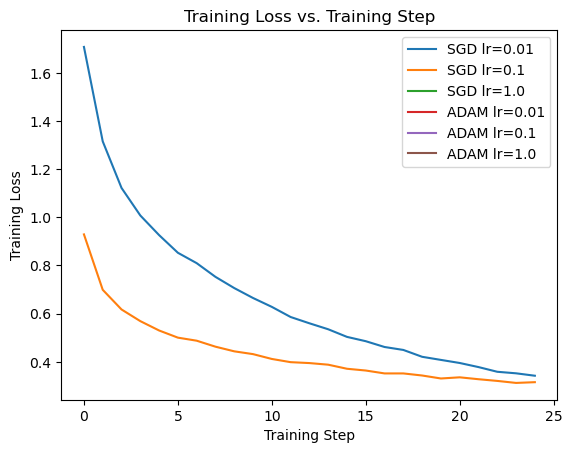

'after training the above 6 cases, the best model is ADAM optimizer with lr=0.01'

In [15]:
# TODO:  Define loss criterion - cross entropy loss
criterion = F.cross_entropy

# TODO Task 4: The Optimizer
def configure_optimizers(model, name='SGD', rate=0.01):
    if name=='SGD':
        optimizer = optim.SGD(model.parameters(), lr=rate, momentum=0.9, weight_decay=1e-4)
    elif name=='ADAM':
        optimizer = optim.AdamW(model.parameters(), lr=rate, weight_decay=1e-4)
    return optimizer

## Train and evaluate

rates = [0.01, 0.1, 1.0]

for lr in rates:
    "SGD optimizer with learning rates of 0.01, 0.1, and 1.0"
    optimizer = configure_optimizers(model, name='SGD', rate=lr)
    name = 'SGD_'+str(lr)+'_.pth'
    _, train_losses = train_model_2(model, criterion, optimizer, save_path=name, is_print=False)
    test_model(model, load_path=name)
    plt.plot(train_losses, label=f"SGD lr={lr}")

for lr in rates:
    "ADAM optimizer with learning rates of 0.01, 0.1, and 1.0"
    optimizer = configure_optimizers(model, name='ADAM', rate=lr)
    name = 'ADAM_'+str(lr)+'_.pth'
    _, train_losses = train_model_2(model, criterion, optimizer, save_path=name, is_print=False)
    test_model(model, load_path=name)
    plt.plot(train_losses, label=f"ADAM lr={lr}")

plt.legend()
plt.title("Training Loss vs. Training Step")
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.show()
"after training the above 6 cases, the best model is SGD optimizer with lr=0.1"

### Display model predictions

In [17]:
## Display model predictions
## Generic function to display predictions for a few images

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, num_workers=4) for x in ['train', 'test']}

def display_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Training complete in 7m 18s
test Acc: 0.8057
Testing complete in 0m 9s


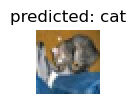

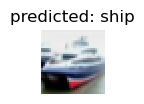

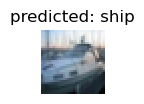

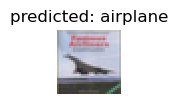

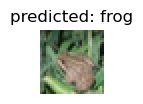

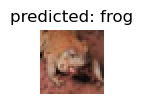

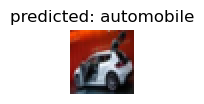

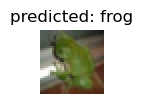

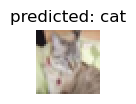

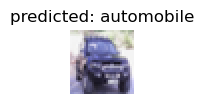

In [20]:
# TODO Diplay your best model predictions
## best_model from num_blocks=[3,3,3], lr=0.01, ADAM optimizer
optimizer = configure_optimizers(model, name='SGD', rate=0.1)
name = 'best_model_SGD0.1.pth'
best_model, _ = train_model_2(model, criterion, optimizer, save_path=name, is_print=False)
test_model(best_model, load_path=name)
display_predictions(best_model, num_images=10)

## Task 5: Feature Visualization (5 points)
Visualize feature maps of the first and the last convolutional layer of your final network using **cifar_example.jpg** as input image. Show the visualization in the report.

#### First layer activations
<img src="https://i.imgur.com/kGB9AuP.png" width="400" align="left">

#### Last layer activations

<img src="https://i.imgur.com/qelH05X.png" width="400" align="left">

In [34]:
#Task 5: Visualization

In [21]:
def transfer_single_img_to_tensor(img_path):
    im = Image.open(img_path)
    img = np.asarray(im)/255
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    inp = (img - mean) / std
    inp = np.asarray(inp, dtype=np.float32)
    inp = inp.transpose((2, 0, 1))
    inp = np.expand_dims(inp, axis=0)
    inp = torch.from_numpy(inp, )
    inputs = inp.to(device)
    return inputs

In [97]:
def feature_imshow(inp, title=None):
    """Imshow for Tensor."""
    print('inp.shape=',inp.shape)
    inp = inp.detach().numpy().transpose((1, 2, 0))
    if False:
        "default setting"
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        inp = std * inp + mean
    else:
        inp = 0.5*inp + 0.5
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [118]:
inputs = transfer_single_img_to_tensor('example_imgs/cifar_example.jpg') # Loads an image and normalizes it
print('inputs.shape=',inputs.shape)
best_model.eval()
with torch.no_grad():
   # TODO: Retrive the first and the last layer feature maps of your best model. (Hint: Move back to CPU)
    best_model.cpu()
    # print(best_model.input_net)
    
    # Get the feature maps
    first_layer_maps = best_model.input_net[0](inputs.cpu()) ##input_net[0] is conv2d
    print('first_layer_maps.shape=',first_layer_maps.shape)
    
    first_conv = first_layer_maps[0]
    first = first_conv.view((first_conv.shape[0], 1, first_conv.shape[1], first_conv.shape[2]))
    print('first_conv.shape=',first_conv.shape, first.shape)

    ### last feature map
    intermediate = best_model.input_net(inputs.cpu())
    num_conv = 9
    for i in range(num_conv):
        intermediate = best_model.blocks[i](intermediate)
    last_conv = intermediate[0]
    last = last_conv.view((last_conv.shape[0], 1, last_conv.shape[1], last_conv.shape[2]))
    print('last_conv.shape=',last_conv.shape, last.shape)

inputs.shape= torch.Size([1, 3, 32, 32])
first_layer_maps.shape= torch.Size([1, 16, 32, 32])
first_conv.shape= torch.Size([16, 32, 32]) torch.Size([16, 1, 32, 32])
last_conv.shape= torch.Size([64, 8, 8]) torch.Size([64, 1, 8, 8])


inp.shape= torch.Size([3, 70, 274])


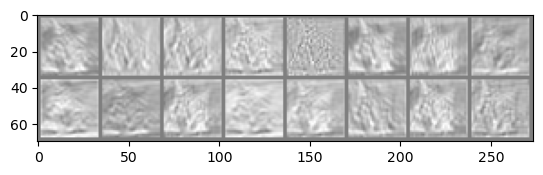

In [120]:
# Visualize the feature maps
out = torchvision.utils.make_grid(first, normalize=True, scale_each=True)
feature_imshow(out)

inp.shape= torch.Size([3, 82, 82])


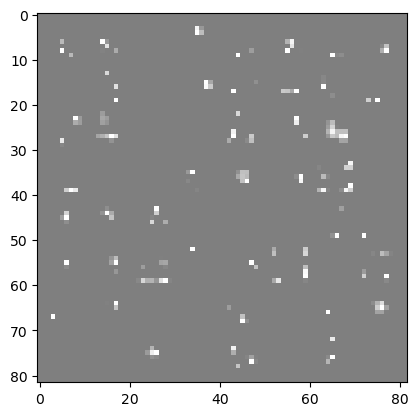

In [122]:
out = torchvision.utils.make_grid(last, normalize=True, scale_each=True)
feature_imshow(out)

## Task 6: Weight Visualization (5 points)
Visualize weights of convolutional layers of your final network. Show the visualization in the report.

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


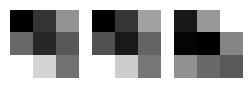

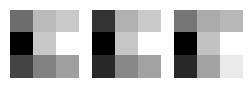

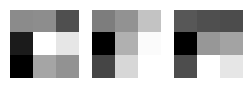

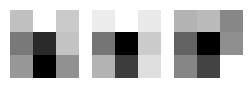

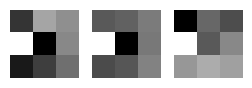

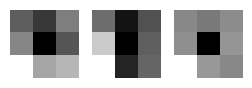

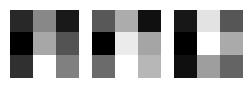

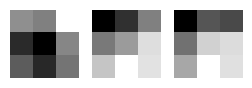

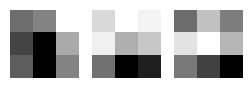

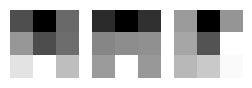

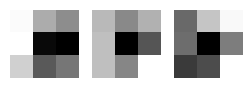

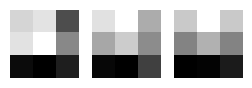

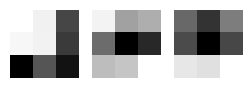

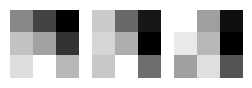

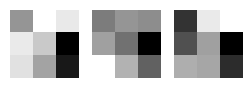

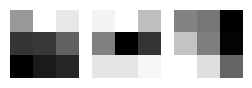

In [161]:
# TODO: Task 6
# Hint: 
# 1) What is the size of each weight (filter) tensor?            ##Hui: [3,3]
# 2) Normalize weight values to [0, 1] 
# 3) Each subfigure should be of size [kernel_size, kernel_size] ##Hui: [3,3]
# 4) How many subfigures in total?                               ##Hui:  3 x 16 = 48

def normalize_weights(conv_layer):
    "Normalize the weights"
    weights = conv_layer.weight.data
    min_val = weights.min().item()
    max_val = weights.max().item()
    weights = (weights - min_val) / (max_val - min_val)
    ## print(max_val, min_val, weights.max(), weights.min()) == 3.0611956119537354 -2.433807134628296 tensor(1.) tensor(0.)
    return weights

conv1 = dict(best_model.input_net.named_children())['0']
print(conv1)

kernel_set = normalize_weights(conv1).detach()
#print(kernel_set) ##shape=(16, 3, 3, 3)

num, kernel_size = kernel_set.shape[0], (kernel_set.shape[2], kernel_set.shape[3])
# print(num, kernel_set.shape) ##16, torch.Size([16, 3, 3, 3])

for i in range(num):
    i_kernel = kernel_set[i]
    #print(i, i_kernel.shape) ##== [3, 3, 3]
    plt.figure(figsize=kernel_size)
    if (len(i_kernel)) > 1:
        for idx, filer in enumerate(i_kernel):
            ##print(idx) ## always 0, 1, 2
            ## print(filer.shape) [3,3]
            plt.subplot(1, kernel_size[0], idx+1) 
            plt.axis('off')
            plt.imshow(filer[ :, :].detach(), cmap='gray') ## 'gray', color: 'bwr'
            